In [1]:
from PIL import Image

# Open BMP image
img = Image.open("dart.bmp")

# Convert and save as JPG
img.convert("RGB").save("dart.jpg", "JPEG")


In [6]:
imageName = 'Dartboard/dart0.jpg'

## Step 1: Viola -Jones

In [21]:
# 1. Read Input Image
frame = cv2.imread(imageName, 1)

# ignore if image is not array.
if not (type(frame) is np.ndarray):
    print('Not image data')
    sys.exit(1)


# 2. Load the Strong Classifier in a structure called `Cascade'
model = cv2.CascadeClassifier(cascade_name)
    
if model.empty():
    print("Error loading cascade")
    sys.exit(1)

# if not model.load(cascade_name): # if got error, you might need `if not model.load(cv2.samples.findFile(cascade_name)):' instead
#     print('--(!)Error loading cascade model')
#     exit(0)

# 3. Detect Faces and Display Result with the model
# Return the detected faces as bounding boxes for evaluation
faces = detectAndDisplay(model,frame)

4


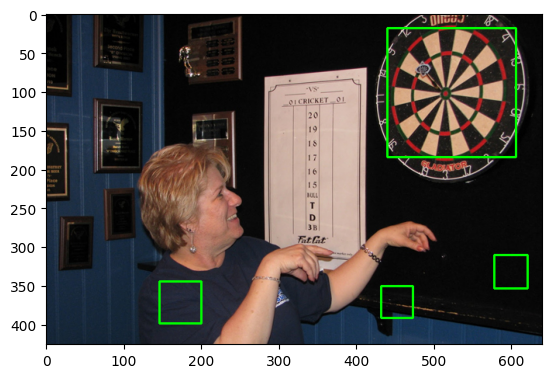

In [4]:
# Displat frame using matplotlib
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Stage 2: ROI Extraction + Hough Transform

In [28]:
frame = cv2.imread(imageName, 1)


In [29]:
# Crop the image to that bounding box and save it as array

crop_imgs = []
for (x, y, w, h) in faces:
    # crop_img = frame[y:y+h, x:x+w]
    # add some border to the cropped image
    border_size = 10
    x1 = np.clip(x - border_size, 0, frame.shape[1])
    y1 = np.clip(y - border_size, 0, frame.shape[0])
    x2 = np.clip(x + w + border_size, 0, frame.shape[1])
    y2 = np.clip(y + h + border_size, 0, frame.shape[0])

    crop_img = frame[y1:y2, x1:x2]
    crop_imgs.append(crop_img)
    # Apply Hough Circle Transform to detect circles in the cropped image

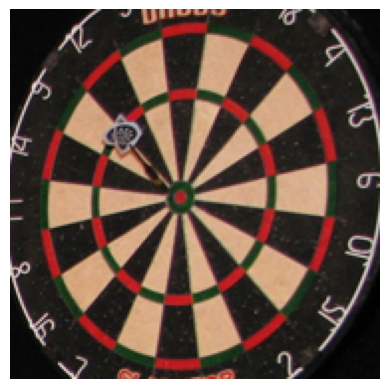

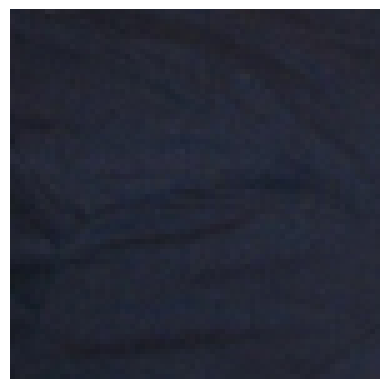

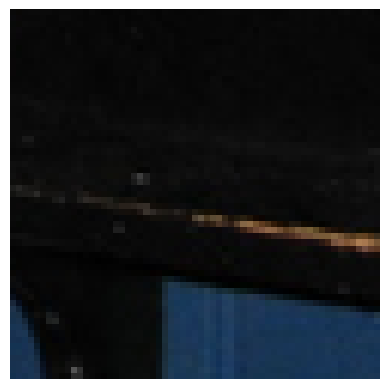

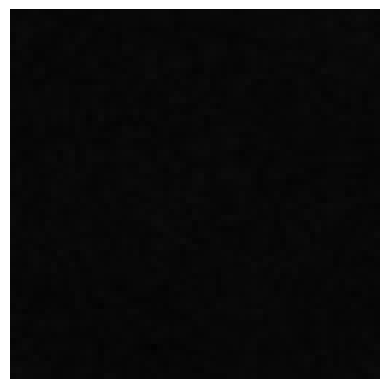

In [ ]:
for crop_img in crop_imgs:
    plt.figure()
    plt.imshow(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [31]:
def sobelEdge(input):
    # intialise the output using the input
    edgeOutputX = np.zeros([input.shape[0], input.shape[1]], dtype=np.float32)
    edgeOutputY = np.zeros([input.shape[0], input.shape[1]], dtype=np.float32)
    # create the Gaussian kernel in 1D
    kernelX = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    kernelY = kernelX.T
    # we need to create a padded version of the input
    # or there will be border effects
    kernelRadiusX = round((kernelX.shape[0] - 1) / 2)
    kernelRadiusY = round((kernelX.shape[1] - 1) / 2)
    paddedInput = cv2.copyMakeBorder(input,
        kernelRadiusX, kernelRadiusX, kernelRadiusY, kernelRadiusY,
        cv2.BORDER_REPLICATE)
    # now we can do the convoltion
    for i in range(0, input.shape[0]):
        for j in range(0, input.shape[1]):
            patch = paddedInput[i:i+kernelX.shape[0], j:j+kernelX.shape[1]]
            edgeOutputX[i, j] = (np.multiply(patch, kernelX)).sum()
            edgeOutputY[i, j] = (np.multiply(patch, kernelY)).sum()
    return edgeOutputX, edgeOutputY

In [32]:
image = crop_imgs[3]
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_image = gray_image.astype(np.float32)
edgemapX, edgemapY = sobelEdge(gray_image)

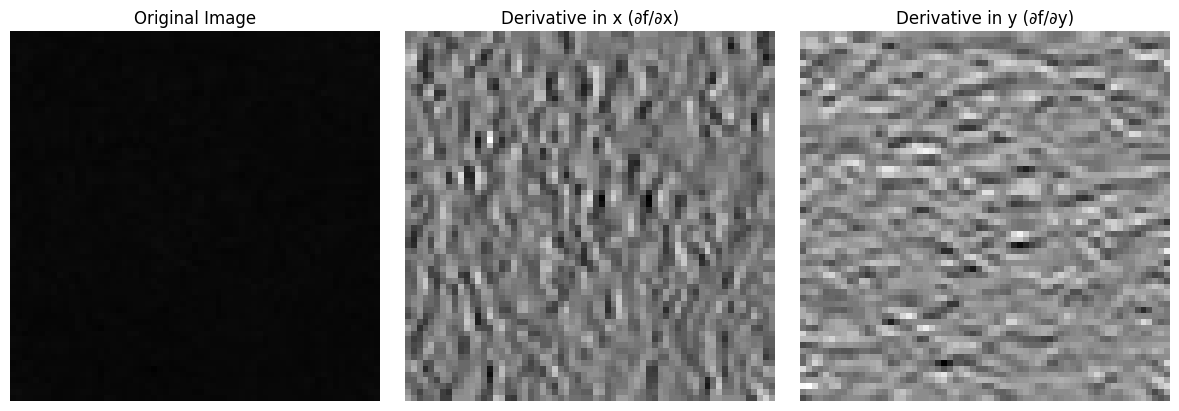

In [33]:
# Display results
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(edgemapX, cmap='gray')
plt.title("Derivative in x (∂f/∂x)")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(edgemapY, cmap='gray')
plt.title("Derivative in y (∂f/∂y)")
plt.axis('off')


plt.tight_layout()

## My Approach

In [34]:
# magnitude
magnitude = np.sqrt(edgemapX**2 + edgemapY**2)

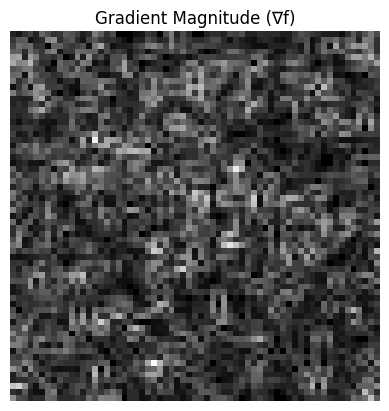

In [35]:
plt.imshow(magnitude, cmap='gray')
plt.title("Gradient Magnitude (∇f)")
plt.axis('off')
plt.show()

In [36]:
epsilon = np.exp(-10)  # A small constant to avoid division by zero
direction = np.arctan(edgemapY / (edgemapX + epsilon)) * (180 / np.pi)

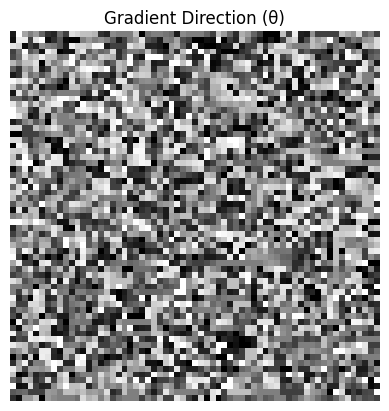

In [37]:
plt.imshow(direction, cmap='gray')
plt.title("Gradient Direction (θ)")
plt.axis('off')
plt.show()

In [38]:
def threshold_magnitude(magnitude, T):
    """
    Thresholds the gradient magnitude image.
    """
    binary = np.zeros_like(magnitude, dtype=np.uint8)
    binary[magnitude > T] = 255
    return binary

In [39]:
threshold_image = threshold_magnitude(magnitude, T=100)

(-0.5, 62.5, 62.5, -0.5)

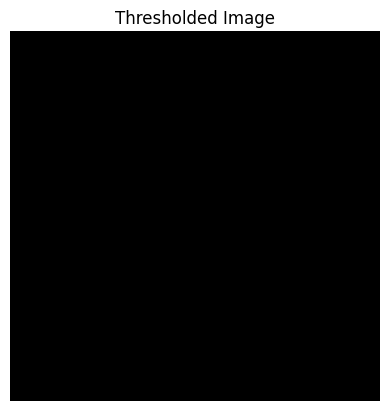

In [40]:
plt.imshow(threshold_image, cmap='gray')
plt.title("Thresholded Image")
plt.axis('off')

In [41]:
def hough_circle(edge_image, direction, min_r, max_r):
    """
    Compute 3D Hough Space (x0, y0, r) for circle detection.
    - edge_image: binary image of edges (thresholded gradient magnitude)
    - direction: gradient direction (in degrees)
    - min_r, max_r: min and max radius to consider
    """
    rows, cols = edge_image.shape

    # Create accumulator array (3D): (x0, y0, r)
    accumulator = np.zeros((rows, cols, max_r - min_r), dtype=np.uint64)

    # Loop through all edge points
    for y in range(rows):
        for x in range(cols):
            if edge_image[y, x] == 255:  # Strong edge pixel
                theta = np.deg2rad(direction[y, x])

                # For each possible radius
                for r in range(min_r, max_r):
                    # Compute possible circle centers along the gradient direction
                    a = int(x - r * np.cos(theta))  # center x0
                    b = int(y - r * np.sin(theta))  # center y0

                    # Check boundaries
                    if 0 <= a < cols and 0 <= b < rows:
                        accumulator[b, a, r - min_r] += 1

    return accumulator


In [42]:
hough_space = hough_circle(threshold_image, direction, 20, 100)

In [43]:
hough_space.shape

(63, 63, 80)

In [44]:
def project_hough_space(accumulator):
    """
    Sums along the radius dimension to project to 2D space.
    """
    return np.sum(accumulator, axis=2)


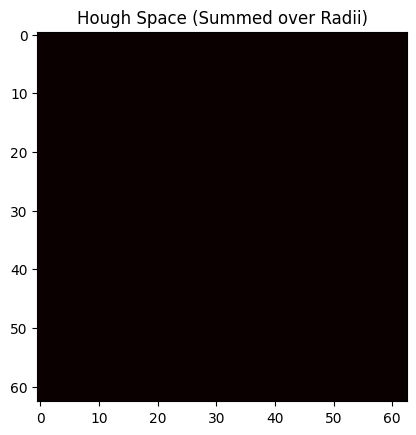

In [45]:
# Step 4: Project and display
hough_2d = project_hough_space(hough_space)
plt.imshow(hough_2d, cmap='hot')
plt.title("Hough Space (Summed over Radii)")
plt.show()

In [46]:
def detect_circles(accumulator, min_r, threshold):
    """
    Find circles (x0, y0, r) where accumulator votes exceed threshold.
    """
    circles = []
    rows, cols, depth = accumulator.shape

    for y in range(rows):
        for x in range(cols):
            for r in range(depth):
                if accumulator[y, x, r] >= threshold:
                    circles.append((x, y, r + min_r))
    return circles


In [47]:
circles = detect_circles(hough_space, 30, threshold=15)

In [48]:
len(circles)

0

In [151]:
def draw_circles(image, circles):
    output = image.copy()
    for (x0, y0, r) in circles:
        cv2.circle(output, (x0, y0), r, (255, 0, 0), 2)
        cv2.circle(output, (x0, y0), 2, (255, 0, 0), 3)  # Mark center
    return output


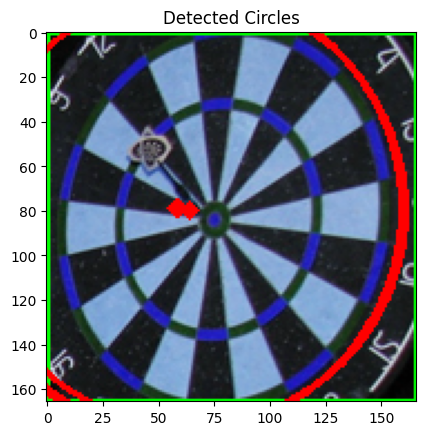

In [124]:
# Step 5: Detect and visualize circles
output_image = draw_circles(img, circles)
plt.imshow(output_image, cmap='gray')
plt.title("Detected Circles")
plt.show()

## Solution Approach

In [73]:
normmagnitude = (magnitude-magnitude.min())/(magnitude.max()-magnitude.min())
# orientation
anglemap = np.arctan2(edgemapY, edgemapX)
# edge
edgemap = normmagnitude > 0.2

In [ ]:
rmin = 20
rmax = 100
hough3D = np.zeros([image.shape[0], image.shape[1], rmax-rmin+1], dtype=np.float32)
for i in range(0, image.shape[0]):  # go through all rows (or scanlines)
    for j in range(0, image.shape[1]):
        if edgemap[i, j] > 0:
            for r in range(rmin, rmax+1):
                x = (j + np.array([-1, 1])*r*np.cos(anglemap[i, j])).astype(int)
                y = (i + np.array([-1, 1])*r*np.sin(anglemap[i, j])).astype(int)
                for k in range(0, 2):
                    if (y[k] >= 0) and (y[k] < image.shape[0]) and (x[k] >= 0) and (x[k] < image.shape[1]):
                        hough3D[y[k], x[k], r-rmin] += 1

hough2D = np.sum(hough3D, axis=2)

In [86]:
hough3D.shape

(166, 166, 100)

In [76]:
hough2D.shape

(166, 166)

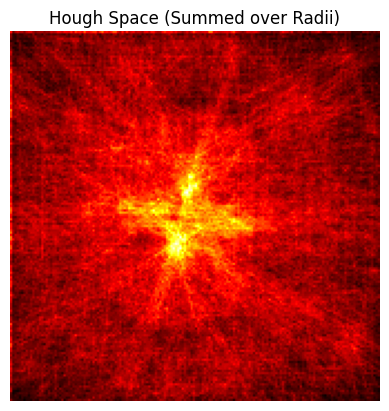

In [93]:
plt.imshow(hough2D, cmap='hot')
plt.title("Hough Space (Summed over Radii)")
plt.axis('off')
plt.show()

In [125]:
circles = detect_circles(hough3D, 30, threshold=15)

In [126]:
len(circles)

15

In [156]:
def detect_circles(accumulator, min_r, threshold):
    """
    Find circles (x0, y0, r) where accumulator votes exceed threshold.
    """
    circles = []
    rows, cols, depth = accumulator.shape

    for y in range(rows):
        for x in range(cols):
            for r in range(depth):
                if accumulator[y, x, r] >= threshold:
                    circles.append((x, y, r + min_r))
    return circles

In [157]:
circles = detect_circles(hough3D, 30, threshold=16)

In [165]:
def detect_circles_new(new, min_r, threshold):
    """
    Find circles (x0, y0, r) where accumulator votes exceed threshold.
    """
    circle_parameters_ls = []
    for i in range(0, hough3D.shape[0]):
        for j in range(0, hough3D.shape[1]):
            for k in range(0, hough3D.shape[2]):
                if hough3D[i, j, k] >= threshold:
                    circle_parameters_ls.append([j, i, k + min_r])
    
    return circle_parameters_ls

In [170]:
circle_parameters_ls = detect_circles_new(hough3D, 20, threshold=16)

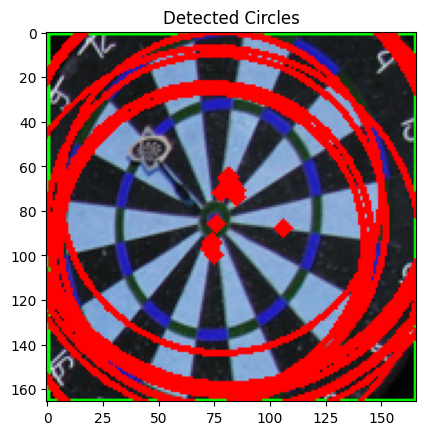

In [169]:
output_image = draw_circles(image, circles)
plt.imshow(output_image, cmap='gray')
plt.title("Detected Circles")
plt.show()

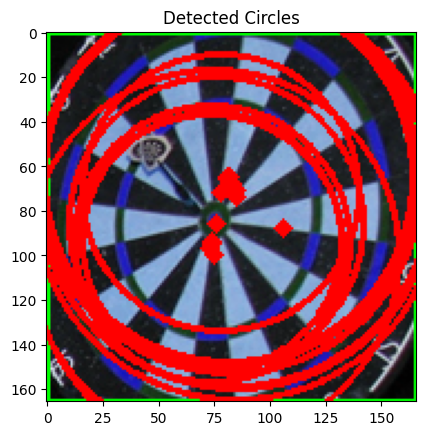

In [171]:
output_image = draw_circles(image, circle_parameters_ls)
plt.imshow(output_image, cmap='gray')
plt.title("Detected Circles")
plt.show()

In [172]:
# Plot the circles according to the parameters on the original image
imagewithcircle = image
for circle_parameters in circle_parameters_ls:
    imagewithcircle = cv2.circle(imagewithcircle,
                                 (circle_parameters[0], circle_parameters[1]),
                                 int(circle_parameters[2]),
                                 color=(0, 0, 255),
                                 thickness=2)

(-0.5, 165.5, 165.5, -0.5)

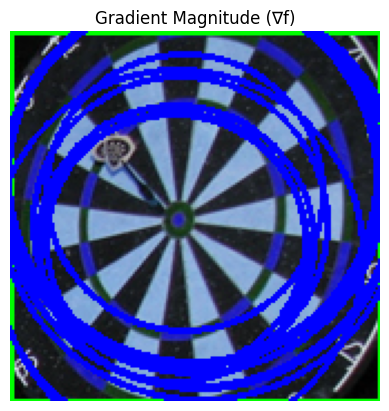

In [173]:
plt.imshow(imagewithcircle, cmap='gray')
plt.title("Gradient Magnitude (∇f)")
plt.axis('off')